# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt  

In [12]:
#print(combined['sat_score'])
#print(survey_fields.dtype())
interested_fields = survey_fields + ['sat_score']
#interested_fields.append('sat_score')
print(interested_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11', 'sat_score']


In [13]:
corr = combined[interested_fields].corr()

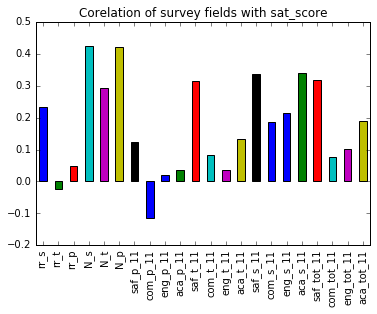

In [14]:
correlation_list = corr['sat_score'][0:-1] # removing last element of sat_score
fig1 = correlation_list.plot.bar()
fig1.set_title('Corelation of survey fields with sat_score')

These are the observations
- There is some correlation between `N_s`, `N_t`, `N_p` and `sat_score`.
- Also `saf_t_11`, `saf_s_11`, `saf_tot_11` are somewhat correlated to high `sat_score`. These correspond to how safe the teachers, students and both percieve the school to be.


## Exploring safety and SAT scores

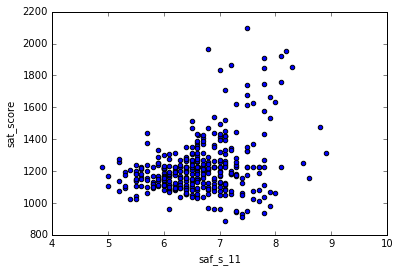

In [15]:
combined.plot.scatter('saf_s_11','sat_score')

There is no clear correlation between the two variables, but one can notice that for some values, higher `saf_s_11` corresponds to a higher SAT score. Possibly because more safe the student feels, he could concentrate more on the studies and give his best. 

In [16]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


#### Analysis of SAT scores by districts

In [17]:
combined['school_dist'].value_counts()

02    48
10    22
09    20
11    15
14    14
17    14
07    13
24    13
13    13
03    12
19    12
12    12
28    11
18    11
08    11
21    11
31    10
06    10
27    10
15     9
30     9
25     8
29     8
05     7
04     7
32     6
01     6
26     5
20     5
22     4
16     4
23     3
Name: school_dist, dtype: int64

In [18]:
#computing avg safety score of each district
avg_saf_dt = combined.groupby(by = 'school_dist').mean()[['sat_score','saf_s_11','lat', 'lon']]

In [19]:
avg_saf_dt.reset_index(inplace = True)
avg_saf_dt

,school_dist,sat_score,saf_s_11,lat,lon
0,01,1354.500000,6.768611,40.719022,-73.982377
1,02,1295.638184,6.910660,40.739699,-73.991386
2,03,1293.443035,6.716667,40.781574,-73.977370
3,04,1224.142857,6.885714,40.793449,-73.943215
4,05,1285.062687,6.314286,40.817077,-73.949251
5,06,1164.643881,6.950000,40.848970,-73.932502
6,07,1128.846154,6.800000,40.816815,-73.919971
7,08,1159.665129,6.364697,40.823803,-73.866087
8,09,1131.971940,6.655000,40.836349,-73.906240
9,10,1222.227273,6.577273,40.870345,-73.898360


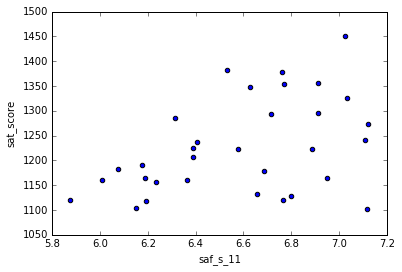

In [20]:
avg_saf_dt.plot.scatter('saf_s_11', 'sat_score')

Here the trend is more clear. **Students are generally scoring more in SAT in the places where they feel they are safe**.


** However there are exceptions too.** Let us look at the geography.

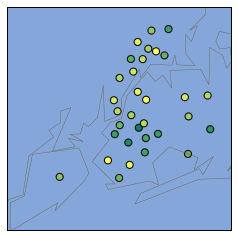

In [21]:
latitudes = avg_saf_dt['lat'].tolist()
longitudes = avg_saf_dt['lon'].tolist()

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
m = Basemap(projection='merc', llcrnrlat=40.496044, urcrnrlat=40.915256, llcrnrlon=-74.255735, urcrnrlon=-73.700272, resolution='i')


m.scatter(longitudes, latitudes, latlon = True, s=50, zorder = 2, c=avg_saf_dt["saf_s_11"], cmap="summer")

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
plt.show()

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

# Exploring Race and SAT scores

In [22]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per', 'sat_score']
race_corr = combined[race_fields].corr()['sat_score'][0:-1] # removing last element of sat_score


In [23]:
race_corr

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

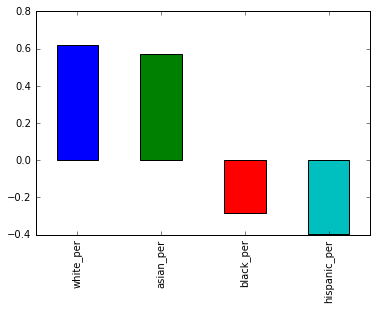

In [24]:
race_corr.plot.bar()

#### Observations
- There is a good positive correlation between the percentage of `white` and `asian` students and SAT scores
- Also, there is negative correlation between the percentage of `black` and `hispanic` students and SAT scores

These may also be related to demographic layout of certain districts. Like say, if a schools of a particular area are from a poor neighbourhood, where certain race population could be concentrated.

To explore further, let us analyse `percentage of hispanic population` vs `SAT score`

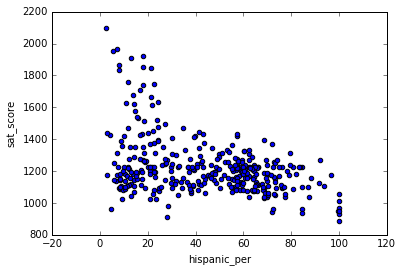

In [25]:
combined[race_fields].plot.scatter(x = 'hispanic_per', y = 'sat_score')

It does look like there is a negative correlation of `SAT score` with `Hispanic percentages` but it should also be noted that there are many schools in which the `SAT scores` were less but had very few hispanic students. Maybe it should be looked from geographic and economic situation perspective to get better insights.

In [29]:
# schools with ver high hispanic percentage
high_hispanic_per = combined[combined['hispanic_per'] > 95]
high_hispanic_per['school_name']

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [30]:
# schools with a hispanic_per less than 10% and an average SAT score greater than 1800
combined[(combined['hispanic_per'] < 10) & (combined['sat_score']> 1800)]['school_name']

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Gender differences and SAT scores

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


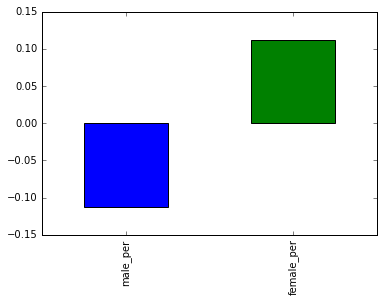

In [32]:
gender_corr = combined[['male_per','female_per','sat_score']].corr()['sat_score'][0:-1]
print(gender_corr)
gender_corr.plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is strong and infact it is very less.

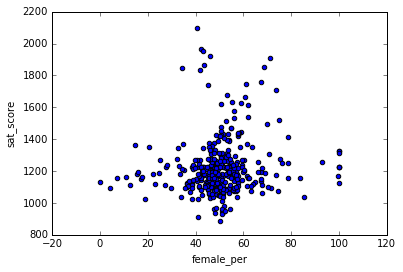

In [33]:
combined.plot.scatter(x = 'female_per', y = 'sat_score')

One can notice a cluster of high female percentages (60 to 80) and high SAT scores

In [35]:
# schools with a hispanic_per less than 10% and an average SAT score greater than 1800
combined[(combined['female_per'] > 60) & (combined['sat_score']> 1700)]['school_name']

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

These schools looks like liberal arts schools with admission tests etc. Possibly suggesting why female percentage is more and high SAT scores.

# Does AP exam takers score higher in SAT exam ? 

ap_per    0.057171
Name: sat_score, dtype: float64


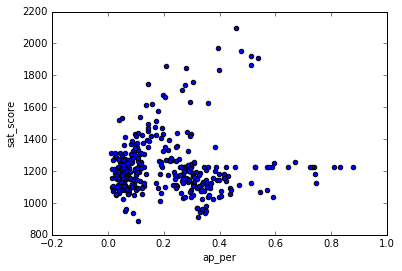

In [37]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
print(combined[['ap_per','sat_score']].corr()['sat_score'][0:-1])
combined.plot.scatter('ap_per','sat_score')

There is no correlation between AP exam and SAT exam takers. Thus it looks like taking AP exam maynot effect the student's performance in the SAT exam

# Bonus: Performance of Blacks and Hispanics compared to other races in SAT exam
Earlier we have seen that White percentage, Asian percentage were positively correlated with SAT scores where as Blacks and Hispanics were negatively coorelated

white_asian_per       0.724385
black_hispanic_per   -0.728650
Name: sat_score, dtype: float64


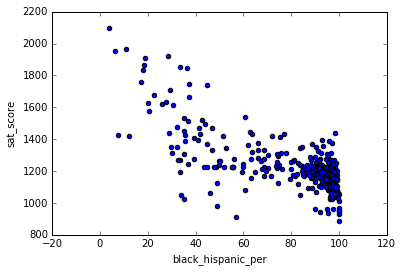

In [38]:
combined['white_asian_per'] = combined['white_per'] + combined['asian_per']
combined['black_hispanic_per'] = combined['black_per'] + combined['hispanic_per']
race_fields = ['white_asian_per', 'black_hispanic_per', 'sat_score' ]
race_corr = combined[race_fields].corr()['sat_score'][0:-1]
print(race_corr)
combined[race_fields].plot.scatter(x = 'black_hispanic_per', y = 'sat_score')

There is a strong negative correlation with percentages of black and hispanics with SAT scores. However it should be looked what financial background blacks and hispanics maybe from, where they would be residing etc, because all these factors may play a big role in SAT exam scores